In [1]:
import open_clip
import torchvision
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt

/home/ubuntu/anaconda3/envs/content_understanding/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32-quickgelu', pretrained='laion400m_e32')
tokenizer = open_clip.get_tokenizer('ViT-B-32-quickgelu')

In [3]:
cifar_train = torchvision.datasets.CIFAR10('/home/ubuntu/data/', train = True, transform = preprocess, download=True)
cifar_test = torchvision.datasets.CIFAR10('/home/ubuntu/data/', train = False, transform = preprocess, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=128, shuffle=False, num_workers=8)
test_loader = torch.utils.data.DataLoader(cifar_test, batch_size=128, shuffle=False, num_workers=8)

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [6]:
all_train_features = None
model.to(device)
all_train_labels = None
for i, (images, labels) in tqdm(enumerate(train_loader), total=len(cifar_train) // 128):
    images = images.to(device)
    model.eval()
    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        image_features = image_features.cpu()
        if all_train_features is None:
            all_train_features = image_features
            all_train_labels = labels
        else:
            all_train_features = torch.concat([all_train_features, image_features])
            all_train_labels = torch.concat((all_train_labels, labels))

391it [00:34, 11.24it/s]                         


In [7]:
all_test_features = None
model.to(device)
all_test_labels = None
for i, (images, labels) in tqdm(enumerate(test_loader), total=len(cifar_test) // 128):
    images = images.to(device)
    model.eval()
    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(images)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        if all_test_features is None:
            all_test_features = image_features
            all_test_labels = labels
        else:
            all_test_features = torch.concat([all_test_features, image_features])
            all_test_labels = torch.concat((all_test_labels, labels))

79it [00:06, 12.87it/s]                        


In [8]:
train_vec_dset = torch.utils.data.TensorDataset(all_train_features.cpu(), all_train_labels.cpu())
test_vec_dset = torch.utils.data.TensorDataset(all_test_features.cpu(), all_test_labels.cpu())
train_vec_loader = torch.utils.data.DataLoader(train_vec_dset, batch_size=128, shuffle=True, num_workers=8)
test_vec_loader = torch.utils.data.DataLoader(test_vec_dset, batch_size=128, shuffle=False, num_workers=8)

In [9]:
def eval(model_):
    model_.eval()
    running_corrects = 0
    total_num = 0
    with torch.no_grad(), torch.cuda.amp.autocast():
        for inputs, labels in test_vec_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data).item()
            total_num += len(labels)
    return running_corrects / total_num

In [10]:
class LinearHead(torch.nn.Module):
    def __init__(self, feature_dim=512, num_classes=10):#, temp_scale=False):
        super().__init__()
        self.fc = torch.nn.Linear(feature_dim, num_classes)
        #self.temp_scale = temp_scale

    def forward(self, x):
        x = self.fc(x)
        return x
        if self.temp_scale:
            temp = run_supervised_tempscaling(x.detach().clone(), labels)
            x = torch.div(x,temp)
            return x, temp
        else:
            return x

In [11]:
criterion = torch.nn.CrossEntropyLoss()
model = LinearHead().train().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
accs = []
for epoch in tqdm(range(10)):
    # Iterate over data.
    with torch.cuda.amp.autocast():
        for inputs, labels in train_vec_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    accs.append(eval(model))

100%|██████████| 10/10 [00:17<00:00,  1.78s/it]


from https://github.com/gpleiss/temperature_scaling

In [12]:
from temperature_scaling import ModelWithTemperature
model_scaled = ModelWithTemperature(LinearHead().train()).to(device)
optimizer = torch.optim.SGD(model_scaled.parameters(), lr=0.001, momentum=0.9)
accs_scaled = []
all_temps = []
for epoch in tqdm(range(10)):
    # Iterate over data.
    with torch.cuda.amp.autocast():
        for inputs, labels in train_vec_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            outputs = model_scaled(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        _, temp, _, _ = model_scaled.set_temperature(train_vec_loader)
        all_temps.append(temp)
    accs_scaled.append(eval(model_scaled))

  0%|          | 0/10 [00:00<?, ?it/s]

Before temperature - NLL: 2.307, ECE: 0.065
Optimal temperature: 1.507
After temperature - NLL: 2.305, ECE: 0.063


 10%|█         | 1/10 [00:02<00:26,  2.89s/it]

Before temperature - NLL: 2.269, ECE: 0.327
Optimal temperature: 1.442
After temperature - NLL: 2.280, ECE: 0.329


 20%|██        | 2/10 [00:05<00:23,  2.93s/it]

Before temperature - NLL: 2.232, ECE: 0.631
Optimal temperature: 1.276
After temperature - NLL: 2.247, ECE: 0.633


 30%|███       | 3/10 [00:08<00:20,  2.91s/it]

Before temperature - NLL: 2.191, ECE: 0.727
Optimal temperature: 0.868
After temperature - NLL: 2.175, ECE: 0.725


 40%|████      | 4/10 [00:11<00:17,  2.91s/it]

Before temperature - NLL: 2.143, ECE: 0.765
Optimal temperature: -14.806
After temperature - NLL: 2.314, ECE: 0.101


 50%|█████     | 5/10 [00:14<00:14,  2.90s/it]

Before temperature - NLL: 2.124, ECE: 0.548
Optimal temperature: -14.810
After temperature - NLL: 2.315, ECE: 0.099


 60%|██████    | 6/10 [00:17<00:11,  2.87s/it]

Before temperature - NLL: 2.127, ECE: 0.539
Optimal temperature: -14.813
After temperature - NLL: 2.315, ECE: 0.099


 70%|███████   | 7/10 [00:20<00:08,  2.88s/it]

Before temperature - NLL: 2.131, ECE: 0.531
Optimal temperature: -14.816
After temperature - NLL: 2.315, ECE: 0.099


 80%|████████  | 8/10 [00:23<00:05,  2.87s/it]

Before temperature - NLL: 2.135, ECE: 0.521
Optimal temperature: -14.820
After temperature - NLL: 2.314, ECE: 0.099


 90%|█████████ | 9/10 [00:25<00:02,  2.86s/it]

Before temperature - NLL: 2.139, ECE: 0.512
Optimal temperature: -14.823
After temperature - NLL: 2.314, ECE: 0.099


100%|██████████| 10/10 [00:28<00:00,  2.88s/it]


custom temp scaling

In [71]:
def T_scaling(logits, args):
  temperature = args.get('temperature', None)
  return torch.div(logits, temperature)
  
def run_supervised_tempscaling(logits, actuals):
    ## Setup LBGFS
    temperature = torch.nn.Parameter((torch.ones(1)).to(device))
    args = {'temperature': temperature}
    criterion = torch.nn.CrossEntropyLoss()

    # Removing strong_wolfe line search results in jump after 50 epochs
    optimizer = torch.optim.LBFGS([temperature], lr=0.001, max_iter=1000, line_search_fn='strong_wolfe')

    temps = []
    losses = []
    def _eval():
        loss = criterion(T_scaling(logits, args), actuals)
        loss.backward()
        temps.append(temperature.item())
        losses.append(loss)
        return loss
    optimizer.step(_eval)
    return temperature.item()

In [98]:
criterion = torch.nn.CrossEntropyLoss()
model_scaled = LinearHead().train().to(device)
optimizer = torch.optim.SGD(model_scaled.parameters(), lr=0.001, momentum=0.9)
all_temps = []
accs_scaled = []
for epoch in tqdm(range(10)):
    # Iterate over data.
    with torch.cuda.amp.autocast():
        for inputs, labels in tqdm(train_vec_loader, total=len(cifar_train) // 128):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            outputs = model_scaled(inputs)
            # Scale
            #with torch.no_grad():
            temp = run_supervised_tempscaling(outputs.detach().clone(), labels)
            outputs = torch.div(outputs, temp)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            all_temps.append(temp)
    accs_scaled.append(eval(model_scaled))

391it [00:12, 32.55it/s]                         
391it [03:44,  1.74it/s]0:12<01:53, 12.58s/it]
391it [12:12,  1.87s/it]3:57<18:21, 137.70s/it]
391it [12:13,  1.88s/it]6:11<47:47, 409.66s/it]
391it [12:16,  1.88s/it]8:25<53:46, 537.82s/it]
391it [12:16,  1.88s/it]0:42<50:47, 609.54s/it]
391it [12:13,  1.88s/it]2:59<43:31, 652.86s/it]
391it [12:11,  1.87s/it]:05:13<33:58, 679.38s/it]
391it [12:10,  1.87s/it]:17:25<23:12, 696.20s/it]
391it [12:13,  1.88s/it]:29:36<11:47, 707.09s/it]
100%|██████████| 10/10 [1:41:50<00:00, 611.04s/it]


In [13]:
eval(model)

0.9184

In [14]:
eval(model_scaled)

0.0029

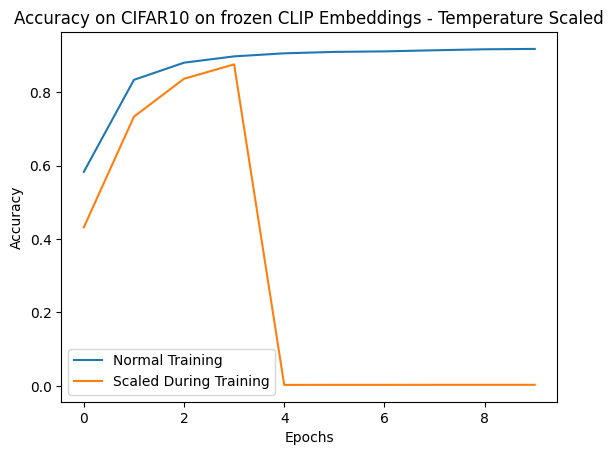

In [15]:
plt.plot(range(len(accs)), accs, label='Normal Training')
plt.plot(range(len(accs_scaled)), accs_scaled, label='Scaled During Training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy on CIFAR10 on frozen CLIP Embeddings - Temperature Scaled')
plt.legend()

Text(0.5, 1.0, 'Supervised Temperature During Training')

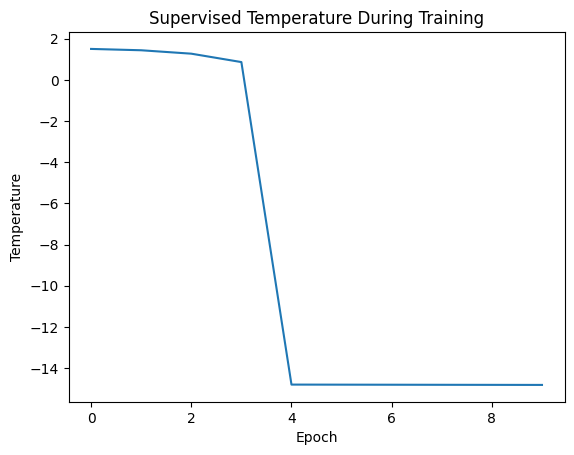

In [17]:
plt.plot(range(len(all_temps)), all_temps)
plt.xlabel('Epoch')
plt.ylabel('Temperature')
plt.title('Supervised Temperature During Training')